In [1]:
import drjit as dr
import matplotlib.pyplot as plt
import mitsuba as mi
from pathlib import Path
from tqdm import tqdm
from typing import List

mi.set_variant('cuda_ad_rgb')

from mimt import *

In [213]:
def create_scene(integrator: str, resolution=(256, 256)):
    scene_dict = mi.cornell_box()

    scene_dict['sensor']['film']['width']  = resolution[1]
    scene_dict['sensor']['film']['height'] = resolution[0]

    scene_dict['integrator']['type']      = integrator
    scene_dict['integrator']['max_depth'] = 5 # limit moderate depth
    scene_dict['sensor']['film']['sample_border'] = True

    # Remove the boxes and add a custom shape
    del scene_dict['large-box']
    del scene_dict['small-box']
    scene_dict['shape'] = {
        'type': 'sphere',
        'radius': 0.5,
        'bsdf': {
            'type': 'roughplastic',
            'diffuse_reflectance': {
                'type': 'rgb',
                'value': [1, 0.6, 0.1]
            }
        }
    }

    return scene_dict

def apply_transform(params: mi.SceneParameters, original: mi.Transform4f, offset: float):
    params['shape.to_world'] = mi.Transform4f().translate([0, 0, -offset]) @ original
    params.update()
    return params

In [214]:
def generate_data(integrators: List[str], spp: int, spp_grad: int):
    data = {}

    # Generate the data for the gi
    data['cornell'] = []
    for integrator in (pbar:= tqdm(integrators, leave=False, desc="integrator")):
        tqdm.write("    "+integrator)
        pbar.set_postfix_str(integrator)
        scene = mi.load_dict(create_scene(integrator=integrator.lower()))

        params   = mi.traverse(scene)
        original = mi.Transform4f(params['shape.to_world'])

        # Render primal image
        img = mi.render(scene, params=params, seed=10, spp=spp, spp_grad=spp_grad)

        # Compute gradients
        render_with_offset = lambda x: mi.render(scene, params=apply_transform(params, original, x), seed=0)
        grad_fd = compute_gradient_finite_differences(render_with_offset, 0., h=0.01)
        grad_fw = compute_gradient_forward(render_with_offset, 0.)
        
        data['cornell'].append((integrator, img, grad_fd, grad_fw))

    return data

In [215]:
def generate_figure(integrators: List[str], data: dict, output_path: Path, grad_projection='red'):
    grad_projection_fn = None
    if grad_projection == 'red':
        grad_projection_fn = lambda grad: grad[...,0]
    elif grad_projection == 'mean':
        grad_projection_fn = lambda grad: dr.mean(grad, axis=-1)
    else:
        raise RuntimeError(f"Unknown gradient projection {grad_projection}")

    num_settings = len(list(data.keys()))

    n_rows = num_settings
    n_cols = 2 + len(integrators)

    aspect = (n_rows / n_cols)
    fig = plt.figure(1, figsize=(FIGURE_WIDTH_ONE_COLUMN, aspect * FIGURE_WIDTH_ONE_COLUMN), constrained_layout=False)
    gs  = fig.add_gridspec(n_rows, n_cols, wspace=0.05, hspace=0.05)
    r = None
    for i, setting in enumerate(data.keys()):
        setting_data = data[setting]
        for j, integrator in enumerate(integrators):
            assert setting_data[j][0] == integrator
            if j == 0:
                # Show primal image
                img = setting_data[j][1]
                ax_img = fig.add_subplot(gs[i, j])
                ax_img.imshow(mi.Bitmap(img).convert(srgb_gamma=True))
                disable_ticks(ax_img)
                
                # Show FD of reference primal image
                grad_fd = grad_projection_fn(setting_data[j][2])
                ax_fd = fig.add_subplot(gs[i, j + 1])
                # init range 
                r = np.quantile(np.abs(grad_fd), 0.89)
                # last setting gets a different range
                if i == 2:
                    r = np.quantile(np.abs(grad_fd), 0.89)*2
                #r = np.maximum(r, 1)
                ax_fd.imshow(grad_fd, cmap='coolwarm', vmin=-r, vmax=r)
                disable_ticks(ax_fd)

                if i == num_settings - 1:
                    ax_img.set_xlabel("Image")
                    ax_fd.set_xlabel("FD")
                
                ax_img.set_ylabel(f"Setting {i+1}")

            # Show forward-mode gradient
            grad_fw = grad_projection_fn(setting_data[j][3])
            ax_fw = fig.add_subplot(gs[i, j + 2])            
            ax_fw.imshow(grad_fw, cmap='coolwarm', vmin=-r, vmax=r)
            disable_ticks(ax_fw)

            if i == num_settings - 1:
                ax_fw.set_xlabel(f"{integrator}")

    plt.show()

In [5]:
data = generate_data(['prb_projective', 'prb_threepoint'], spp=256, spp_grad=32)

integrator:   0%|          | 0/2 [00:00<?, ?it/s]

integrator:   0%|          | 0/2 [00:00<?, ?it/s, prb_projective]

    prb_projective


integrator:  50%|█████     | 1/2 [00:27<00:27, 27.64s/it, prb_threepoint]

    prb_threepoint


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.5178728].


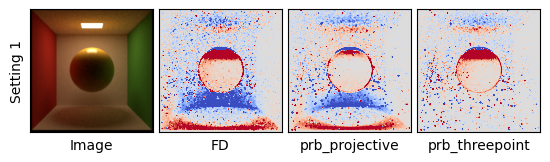

In [6]:
generate_figure(['prb_projective', 'prb_threepoint'], data, "", grad_projection='red')

In [279]:
scene_dict = create_scene('prb_projective', resolution=(128, 128))
scene_dict['shape']['type'] = 'ply'
del scene_dict['shape']['radius']
scene_dict['shape']['filename'] = 'data/teapot.ply'
scene_dict['shape']['to_world'] = mi.ScalarTransform4f().translate([0,-0.3,0]).rotate([0, 1, 0], -150).rotate([1, 0, 0], -110).scale(0.25)
scene = mi.load_dict(scene_dict)
params = mi.traverse(scene)

vertex_positions_original = mi.Float(params['shape.vertex_positions'])
vertex_normals_original   = mi.Float(params['shape.vertex_normals'])

spp_ref = 128
spp_opt = 16

img_ref = mi.render(scene, spp=spp_ref)
mi.Bitmap(img_ref)

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [128, 128],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.4703906e-11..3.5011888].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.0887528e-11..3.4988265].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3.2381145e-10..3.5037682].


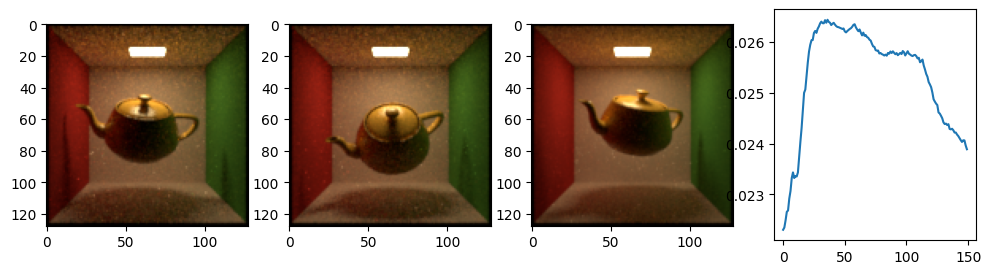

In [ ]:
# Generate the data for the pose estimation experiment
# def generate_data_pose_estimation(integrators: List[str], spp_ref: int, spp_opt: int, spp_opt_grad: int):

rng = np.random.default_rng(0)

opt = mi.ad.Adam(lr=1e-2)
t = 0.2
opt['offset'] = t*mi.Point3f(0.5*(2*rng.random(3)-1))
opt['quat']   = (1-t)*mi.Quaternion4f(1) + t*mi.Quaternion4f(2*rng.random(4)-1)

losses = []
for it in range(150):
    q_opt = dr.normalize(opt['quat'])
    R_opt = dr.quat_to_matrix(q_opt)
    transform_opt = mi.Transform4f().translate(opt['offset']) @ mi.Transform4f(R_opt)

    vertex_positions_opt = transform_opt.transform_affine(dr.unravel(mi.Point3f, vertex_positions_original))
    params['shape.vertex_positions'] = dr.ravel(vertex_positions_opt)
    params.update()

    img_opt = mi.render(scene, params=params, spp=2*spp_opt, spp_grad=spp_opt)

    loss = dr.mean(dr.abs(img_opt - img_ref))
    dr.backward(loss)
    opt.step()

    if it == 0:
        img_init = dr.detach(dr.copy(img_opt))

    dr.print(f"Iteration {it}, Loss {loss}", end='\r')
    losses.append(dr.detach(loss))

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
axs[0].imshow(mi.Bitmap(img_init).convert(srgb_gamma=True))
axs[1].imshow(mi.Bitmap(img_opt).convert(srgb_gamma=True))
axs[2].imshow(mi.Bitmap(img_ref).convert(srgb_gamma=True))
axs[3].plot([l.numpy() for l in losses])